In [ ]:
! pip install --quiet langdetect
! pip install networkx

In [1]:
from pyspark.sql import SparkSession, Row

spark = SparkSession \
    .builder \
    .appName("Retweet Regression Data") \
    .config("spark.jars", "/home/jovyan/work/gcs-connector-hadoop2-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "/home/jovyan/work/key.json") \
    .config("spark.driver.memory", "24g") \
    .config("spark.driver.maxResultSize", "20g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

In [2]:
from datetime import datetime

tweets = spark.read.parquet('gs://spain-tweets-warehouse')

tweets = tweets \
    .where(tweets.datestamp >= datetime(2017,8,1)) \
    .where(tweets.datestamp < datetime(2017,8,2))

tweets.createOrReplaceTempView('tweets')

In [17]:
from langdetect import detect_langs
from langdetect.lang_detect_exception import LangDetectException
from itertools import permutations

def confident_lang(text):
    try: 
        langs = detect_langs(text)
        top = langs[0]
        if top.prob > 0.75:
            return top.lang
        elif top.lang == 'cat' or top.lang == 'es':
            # print(f'could not find language.\n Probs: {langs}.\n Text: {text}')
            return None
        else:
            return None
    except LangDetectException:
        return None
    
    
def user_lang(di):
    """Picks the language of the user

    :param di: dictionary of language-> percentage
    :returns: language picked for user, as a string
    
    Examples
    --------
    >>> user_lang({ 'es': .7, 'en': .3 })
    es

    """
    if di.get('ca', 0) > 0.10:
        return 'ca'
    
    lang,val = None,0

    for k,v in di.items():
        if v > val:
            lang,val = k,v

    return lang

def create_user(di):
    lang = user_lang(di['langs'])
    return (lang, di['retweets'])


def user_stats(user_info, user_networks, users, user):

    # this allows network to be decoupled from this stage
    users = [(u, user_info[u]) for u in users if u != user]

    get_lang = lambda lang: [id_ for id_, (lang, _) in users
                             if lang == lang]
 
    # compute wanted stats:
    tot_engaged = len(users)
    tot_cat_engaged = len(get_lang('cat'))
    user_lang, _ = user_info[user]
    net_size = user_networks[user]

    return user, user_lang, tot_engaged, tot_cat_engaged, net_size


def get_stats_for_users(user_info, user_networks, tweet, lang, users):
    stats = [user_stats(user_info, user_networks, users, user)
             for user in users]

    # TODO: add tweet language...
    stats = [(tweet, lang) + s for s in stats]
    return stats


In [7]:
# NOTE: not getting extended text!!!
# text should not be used for anything!!
query = """
SELECT retweeted_status.id AS id, 
       retweeted_status.text as text,
       user.id AS user
FROM tweets 
WHERE retweeted_status IS NOT NULL
"""

df = spark.sql(query)
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: long (nullable = true)



In [8]:
partitions = int(df.rdd.getNumPartitions() * 8)
Tweet = Row('id', 'text', 'user', 'lang')

tweets = df.rdd \
           .repartition(partitions) \
           .map(lambda x: x.asDict(True)) \
           .map(lambda d: {**d, 'lang': confident_lang(d['text'])}) \
           .filter(lambda d: d['lang'] is not None) \
           .map(lambda d: Tweet(*d.values())) \
           .toDF() \
           .cache()

tweets.createOrReplaceTempView('tweets')
tweets.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: long (nullable = true)
 |-- lang: string (nullable = true)



In [9]:
query = """
with t as (
SELECT 
    id, 
    first(lang) as lang, 
    count(*) as count, 
    collect_set(user) as users 
FROM tweets
GROUP BY id
)
SELECT *
FROM t
WHERE count > 1
"""

tweet_users = spark.sql(query).cache()
tweet_users.createOrReplaceTempView('tweet_users')
tweet_users.printSchema()

root
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- count: long (nullable = false)
 |-- users: array (nullable = true)
 |    |-- element: long (containsNull = true)



In [10]:
%%time

query = """

with tt as (
with t as (
SELECT COUNT(*) as lang_counts, user, lang
FROM tweets
GROUP BY user, lang
)
SELECT SUM(lang_counts) OVER (partition by user) as retweets,
       lang_counts, 
       lang,
       user
FROM t
)
SELECT map_from_arrays(collect_list(lang), collect_list(lang_counts / retweets)) as langs,
       FIRST(retweets) as retweets,
       user
FROM tt
GROUP BY user
"""

user_info = spark.sql(query) \
    .rdd \
    .map(lambda r: (r.user, r.asDict())) \
    .mapValues(create_user) \
    .collectAsMap()

CPU times: user 444 ms, sys: 116 ms, total: 560 ms
Wall time: 13min 5s


In [11]:
%%time

user_networks = tweet_users \
    .rdd \
    .map(lambda r: r.asDict()) \
    .flatMap(lambda d: permutations(d['users'], 2)) \
    .map(lambda t: (t[0], 1)) \
    .reduceByKey(lambda a,b: a + b) \
    .collectAsMap()

In [18]:
%%time

bc_ui = spark.sparkContext.broadcast(user_info)
bc_un = spark.sparkContext.broadcast(user_networks)

reg_data = tweet_users \
    .rdd \
    .map(lambda r: r.asDict()) \
    .flatMap(lambda d: get_stats_for_users(bc_ui.value, bc_un.value, d['id'], d['lang'], d['users'])) \
    .collect()

In [19]:
import pandas as pd

cols = ['id', 'lang', 'user', 'user_lang', 'engaged', 'cat_engaged', 'net_size']
reg_data = pd.DataFrame(reg_data, columns=cols)

In [20]:
reg_data

,id,lang,user,user_lang,engaged,cat_engaged,net_size
0,18446934900,pt,736963905000460290,pt,24,24,24
1,18446934900,pt,750138123972116480,pt,24,24,24
2,18446934900,pt,555483136,pt,24,24,24
3,18446934900,pt,2841569005,pt,24,24,24
4,18446934900,pt,734018507084595200,pt,24,24,40
...,...,...,...,...,...,...,...
759664,892521149934055424,pt,3312694619,pt,1,1,1
759665,892526095861526528,es,152445011,es,1,1,1
759666,892526095861526528,es,244033865,es,1,1,55
759667,892530520248242176,pt,3424639085,pt,1,1,12345


In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

,0,1,2,3,4,5,6,7,8,9,10
count,332836.0,21171.0,3568.0,1120.0,354.0,97.0,19.0,4.0,0.0,1.0,NaN
bucket,1.0,4420.0,8839.0,13258.0,17677.0,22096.0,26515.0,30934.0,35353.0,39772.0,44191.0


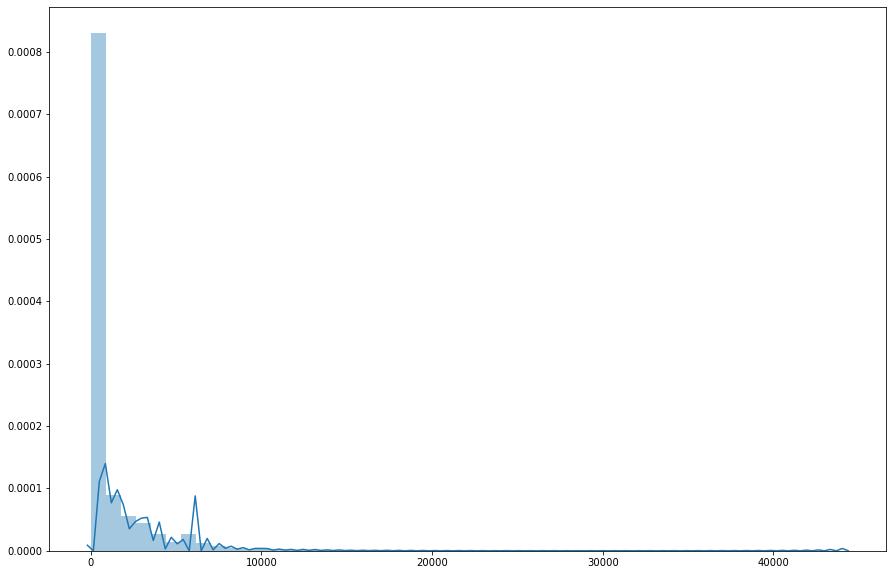

In [39]:
import numpy as np
import seaborn as sns

# Number of edges per userb
edges = np.array(list(user_networks.values()))
sns.distplot(edges)

pd.DataFrame(np.histogram(edges), index=['count', 'bucket'])

,0,1,2,3,4,5,6,7,8,9,10
count,71538.0,48.0,21.0,4.0,7.0,3.0,2.0,1.0,1.0,2.0,NaN
bucket,2.0,618.7,1235.4,1852.1,2468.8,3085.5,3702.2,4318.9,4935.6,5552.3,6169.0


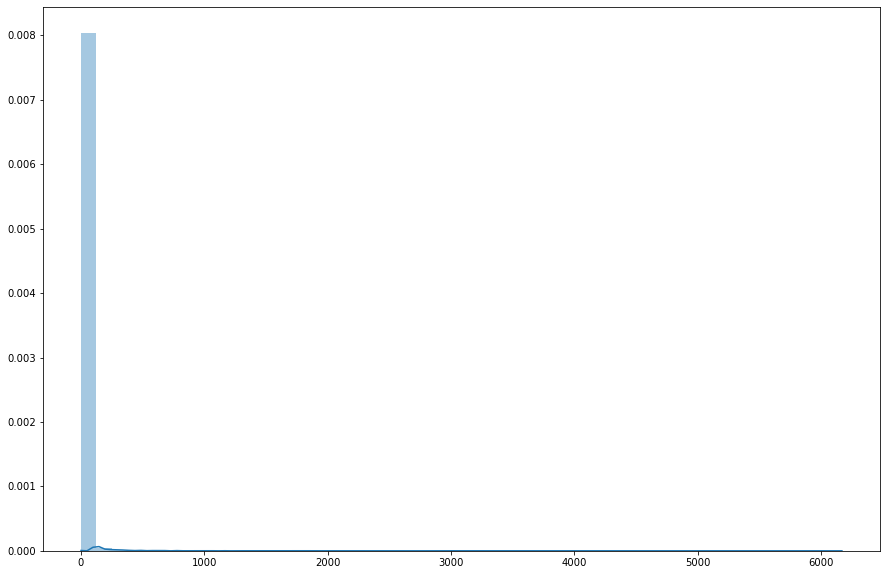

In [40]:
retweet_counts = np.array(spark.sql('SELECT count FROM tweet_users').rdd.map(lambda r: r['count']).collect())

# Number of retweets per tweet
sns.distplot(retweet_counts)
pd.DataFrame(np.histogram(retweet_counts), index=['count', 'bucket'])